<a href="https://colab.research.google.com/github/woowal/YOLO_NAS_Custom_Data/blob/main/YOLO_NAS_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install super-gradients==3.5.0
!pip install opencv-python
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

  Using cached pytube-15.0.0-py3-none-any.whl (57 kB)


In [ ]:
import cv2
import torch
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
#-- GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

[2024-03-31 04:33:37] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-31 04:33:37] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-31 04:33:45] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-03-31 04:33:47] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-31 04:33:47] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-31 04:33:47] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


cuda:0
True
Tesla T4


In [ ]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='potato_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
#커스텀 데이터셋 가져오기
from roboflow import Roboflow
rf = Roboflow(api_key="zvkzBMi7kSL5hhiyz46i")
project = rf.workspace("yoloprac-ljuxs").project("sweet-or-not")
version = project.version(3)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to sweet-or-not-3 in yolov5pytorch:: 100%|██████████| 234/234 [00:00<00:00, 11548.17it/s]


In [ ]:
dataset_params = {
    'data_dir':'/content/sweet-or-not-3',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['potato', 'sweetpotato']
}

In [ ]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
        # 'show_all_warnings': True
    },
    dataloader_params={
        'batch_size':10,
        'num_workers':5
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':10,
        'num_workers':5
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':10,
        'num_workers':5
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 12/12 [00:00<00:00, 3575.20it/s]


In [ ]:
train_data.dataset.transforms
train_data.dataset.dataset_params['transforms'][1]
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

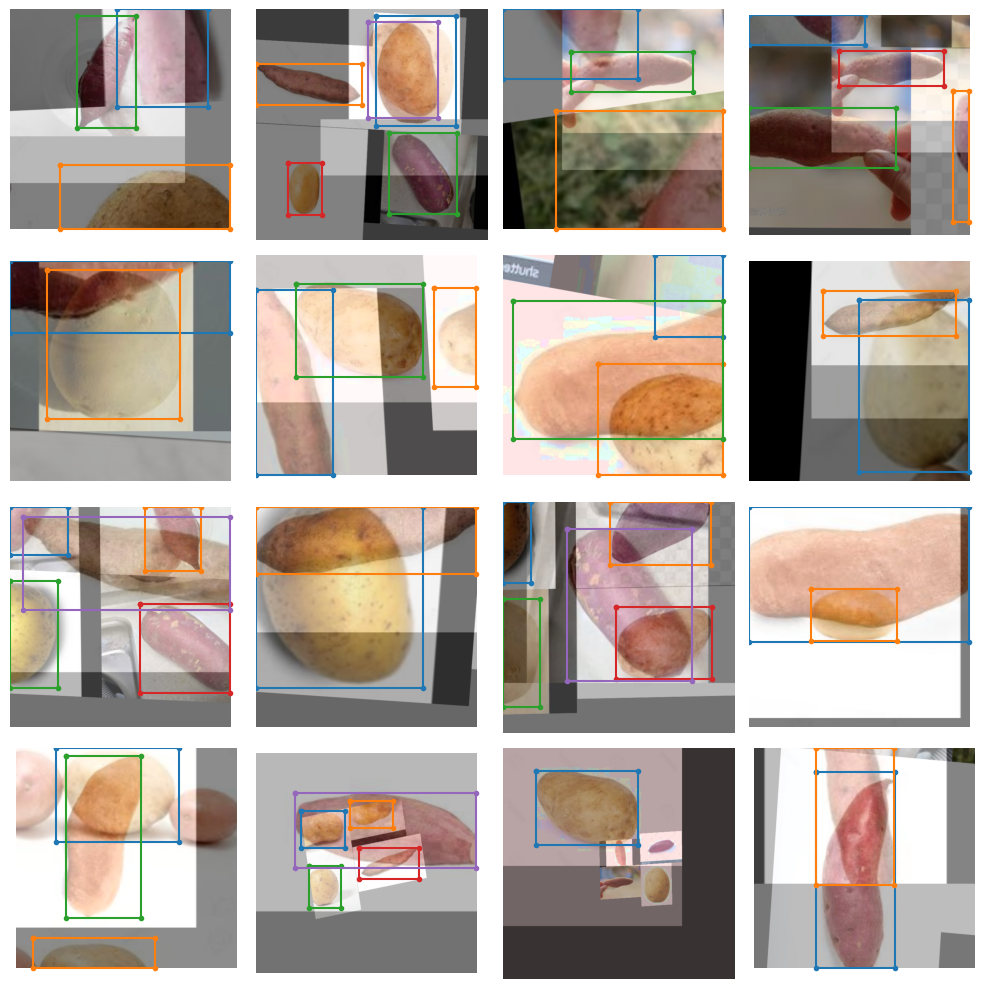

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-03-31 04:34:27] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:08<00:00, 31.3MB/s]
[2024-03-31 04:34:36] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # 이 예제의 경우 15개의 에포크만 교육한다.
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # 참고: num_classes는 여기에 정의되어야 한다.
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # 참고: num_classes는 여기에 정의되어야 한다.
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-03-31 04:34:43] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240331_043443_032069`
[2024-03-31 04:34:43] INFO - sg_trainer.py - Checkpoints directory: checkpoints/potato_yolonas_run/RUN_20240331_043443_032069
[2024-03-31 04:34:43] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader run

The console stream is now moved to checkpoints/potato_yolonas_run/RUN_20240331_043443_032069/console_Mar31_04_34_43.txt


[2024-03-31 04:34:46] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            82         (len(train_set))
    - Batch size per GPU:           10         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             10         (num_gpus * batch_size)
    - Effective Batch size:         10         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         8          (len(train_loader))
    - Gradient updates per epoch:   8          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (84.69K parameters), WD: 0.0001, (66.82M parameters)

[2024-03-31 04:35:09] INFO - base_sg_logger.py - Checkpoint saved i

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/potato_yolonas_run/RUN_20240331_043443_032069/ckpt_best.pth")

[2024-03-31 05:45:06] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/potato_yolonas_run/RUN_20240331_043443_032069/ckpt_best.pth EMA checkpoint.


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

{'PPYoloELoss/loss_cls': 0.6572037,
 'PPYoloELoss/loss_iou': 0.17542015,
 'PPYoloELoss/loss_dfl': 0.36833248,
 'PPYoloELoss/loss': 1.2009563,
 'Precision@0.50': 0.18151970207691193,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9339934587478638,
 'F1@0.50': 0.30712366104125977}

Testing: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


[2024-03-31 05:45:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


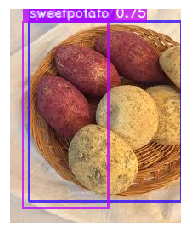

In [ ]:
img = cv2.imread("/content/test3.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
outputs = model.predict(img)
outputs.show()